In [42]:
import argparse
from configparser import ConfigParser
from importlib import import_module
import torch
import pandas as pd
import albumentations as A
import numpy as np
from tqdm import tqdm
import os
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from dataset import CustomDataLoader
from utils import collate_fn
from augmentation import get_validation_augmentation, get_preprocessing


config = ConfigParser()
config.read('./configs/config.ini')

['./configs/config.ini']

In [43]:
dataset_path = config.get('path', 'dataset_path')
test_path = os.path.join(dataset_path,'train_all.json')
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder_name = config.get('model','encoder_name')
encoder_weight = config.get('model','encoder_weight')
architecture = config.get('model','architecture')
preprocessing = config.getboolean('hyper_params', 'preprocessing')

model = getattr(import_module("segmentation_models_pytorch"),architecture) 

preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder_name, encoder_weight)

model = model(
    encoder_name=encoder_name, 
    encoder_weights=encoder_weight,
    in_channels=3,
    classes=11
)
test_transform = get_validation_augmentation()
test_dataset = CustomDataLoader(data_dir=test_path, mode='train', transform=test_transform, preprocessing=get_preprocessing(preprocessing_fn) if preprocessing else False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=1,
                                        num_workers=4,
                                        collate_fn=collate_fn)
model_path = './saved/exp64/best_mIoU.pt'
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint.state_dict()
model.load_state_dict(state_dict)

submission = pd.read_csv('sample_submission.csv', index_col=None)

size = 256
transform = A.Compose([A.Resize(size,size)])
print('Start prediction')

model.eval()

file_name_list = []
preds_array = np.empty((0, size*size), dtype=np.long)

loading annotations into memory...
Done (t=5.48s)
creating index...
index created!
Start prediction


In [44]:
img_score = {}
img_predict = {}
with torch.no_grad():
    for step, (imgs, masks, image_infos) in enumerate(test_loader):
        model = model.to(device)
        outs = model(torch.stack(imgs).to(device).float())
        oms = torch.argmax(outs, dim=1)
        m = torch.nn.Softmax(dim=1)
        tmp = m(outs)
        a = torch.max(tmp, dim=1)
        
        masks = masks[0].to(device)
        
        
        out_tensor = torch.sub(oms.squeeze(), masks)
        cnt_nonezero = torch.count_nonzero(out_tensor)
        
        IoU = round(1 - int(cnt_nonezero)/(512*512), 3)
        
        if IoU < 0.5:
            img_score[step] = IoU
            img_predict[step] = oms.detach().cpu().numpy()
            print(f"Added! IoU = {IoU}")
        # for i, j in zip(a[0], image_infos):
        #     img_score[step] = torch.mean(i)
        #     img_predict[step] = oms.detach().cpu().numpy()
        
        
        # oms = torch.argmax(outs.squeeze(), dim=1).detach().cpu().numpy()

        # temp_mask = []
        # for img, mask in zip(np.stack(imgs), oms):
        #     transformed = transform(image=img, mask=mask)
        #     mask = transformed['mask']
        #     temp_mask.append(mask)
        
        # oms = np.array(temp_mask)

        # oms = oms.reshape([oms.shape[0], size*size]).astype(int)
        # preds_array = np.vstack((preds_array, oms))

        # file_name_list.append([i['file_name'] for i in image_infos])

Added! IoU = 0.435
Added! IoU = 0.477


In [33]:
img_score_sort = sorted(img_score.items(), key=lambda x: x[1])

In [34]:
img_score_sort

[(98, 0.435), (117, 0.477)]

In [35]:
from pycocotools.coco import COCO
coco = COCO('/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/train_all.json')

loading annotations into memory...
Done (t=4.64s)
creating index...
index created!


In [36]:
import cv2
import matplotlib.pyplot as plt
import webcolors
from matplotlib.patches import Patch
category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_colormap = pd.read_csv("/opt/ml/segmentation/baseline_code/class_dict.csv")
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

batch_01_vt/0128.jpg 0.435


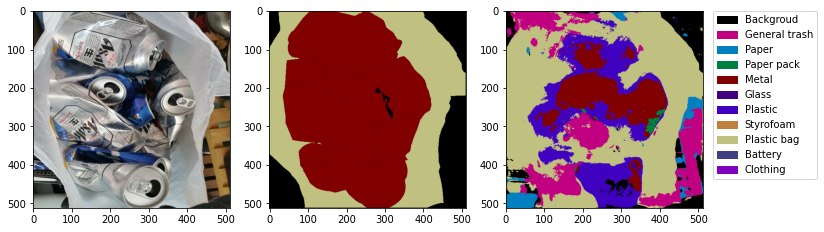

batch_01_vt/0151.jpg 0.477


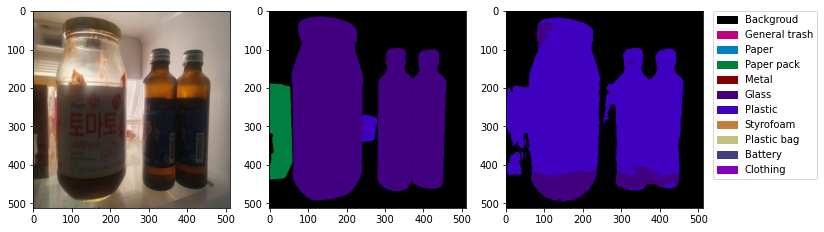

In [37]:
for idx, score in img_score_sort:
    image_id = coco.getImgIds(idx)
    image_infos = coco.loadImgs(image_id)[0]
    images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
    images /= 255.0

    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    masks = np.zeros((image_infos["height"], image_infos["width"]))
    oms = img_predict[idx]
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)
    print(image_infos['file_name'], score)
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,12))
    ax[0].imshow(images)
    ax[1].imshow(label_to_color_image(masks))
    ax[2].imshow(label_to_color_image(oms[0]))
    ax[2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    plt.show()